In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D,GlobalAveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore") 

In [2]:
data_dir="D:\DL\Skin-cancer\hamdata/"

In [3]:
Disease=[]
for file in os.listdir(data_dir):
    Disease+=[file]
print(Disease)
print(len(Disease))

['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Dermatofibroma', 'Melanocytic nevi', 'Melanoma', 'Vascular lesions']
7


In [4]:
train_dir = os.path.join(data_dir)

train_data = []
for defects_id, sp in enumerate(Disease):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'LabelID', 'Label'])
train.head()

,File,LabelID,Label
0,Actinic keratoses/ISIC_0024329.jpg,0,Actinic keratoses
1,Actinic keratoses/ISIC_0024468.jpg,0,Actinic keratoses
2,Actinic keratoses/ISIC_0024470.jpg,0,Actinic keratoses
3,Actinic keratoses/ISIC_0024511.jpg,0,Actinic keratoses
4,Actinic keratoses/ISIC_0024539.jpg,0,Actinic keratoses


In [5]:
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train))  # Reset indices
train.tail()

,File,LabelID,Label
1049,Basal cell carcinoma/ISIC_0029919.jpg,1,Basal cell carcinoma
1050,Benign keratosis-like lesions/ISIC_0027332.jpg,2,Benign keratosis-like lesions
1051,Actinic keratoses/ISIC_0029549.jpg,0,Actinic keratoses
1052,Vascular lesions/ISIC_0032919.jpg,6,Vascular lesions
1053,Melanocytic nevi/ISIC_0033602.jpg,4,Melanocytic nevi


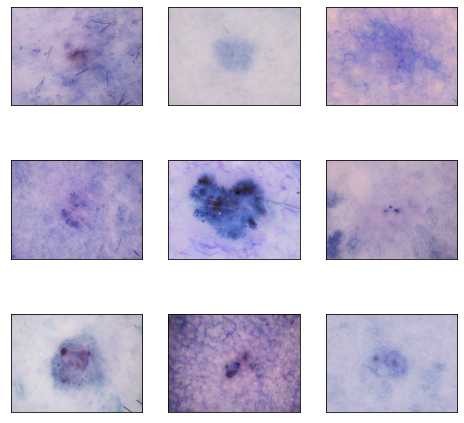

In [6]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(8, 8))
    defect_files = train['File'][train['Label'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1


plot_defects('Basal cell carcinoma', 3, 3)

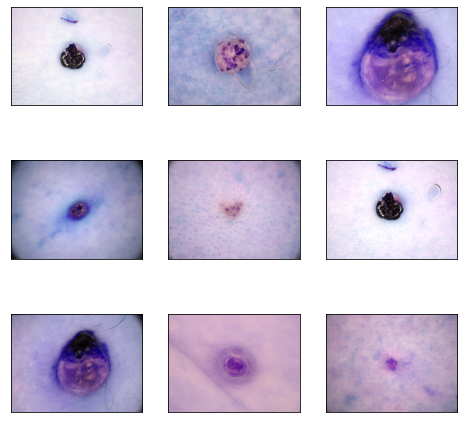

In [7]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(8, 8))
    defect_files = train['File'][train['Label'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1


plot_defects('Vascular lesions', 3, 3)

In [8]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2)


train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    class_mode='categorical')

Found 1054 images belonging to 7 classes.


In [9]:
IMAGE_SIZE = 128


def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))


def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [10]:
x_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        x_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))


x_train = x_train / 255.

num_classes=7
y_train = train['LabelID'].values
y_train = to_categorical(y_train,num_classes)

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=SEED)
print('Train Shape: {}'.format(X_train.shape))
print('Train Shape: {}'.format(Y_train.shape))

1054it [01:00, 17.51it/s]


Train Shape: (737, 128, 128, 3)
Train Shape: (737, 7)


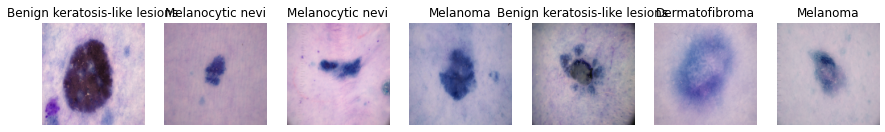

In [11]:
fig, ax = plt.subplots(1, 7, figsize=(15, 15))
for i in range(7):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(Disease[np.argmax(Y_train[i])])

In [12]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (128,128,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))

model.add(Dense(num_classes, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0

In [13]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [14]:
hist=model.fit(X_train,Y_train,epochs=30,batch_size=5,validation_data=(X_test,Y_test))

Epoch 1/30
148/148 [==============================] - 102s 670ms/step - loss: 2.6950 - accuracy: 0.1995 - val_loss: 1.9102 - val_accuracy: 0.2839
Epoch 2/30
148/148 [==============================] - 97s 654ms/step - loss: 1.8693 - accuracy: 0.2592 - val_loss: 1.8197 - val_accuracy: 0.2808
Epoch 3/30
148/148 [==============================] - 96s 652ms/step - loss: 1.7437 - accuracy: 0.3324 - val_loss: 1.8231 - val_accuracy: 0.3281
Epoch 4/30
148/148 [==============================] - 96s 649ms/step - loss: 1.7327 - accuracy: 0.3555 - val_loss: 1.6968 - val_accuracy: 0.3438
Epoch 5/30
148/148 [==============================] - 100s 677ms/step - loss: 1.6703 - accuracy: 0.3908 - val_loss: 1.6120 - val_accuracy: 0.3502
Epoch 6/30
148/148 [==============================] - 98s 662ms/step - loss: 1.5838 - accuracy: 0.4138 - val_loss: 1.6078 - val_accuracy: 0.3533
Epoch 7/30
148/148 [==============================] - 98s 665ms/step - loss: 1.4529 - accuracy: 0.4912 - val_loss: 1.6671 - val_

In [15]:
model.evaluate(X_test, Y_test)
model.save("D:\DL\Skin-cancer\model\CNN.h5")

10/10 [==============================] - 3s 302ms/step - loss: 19.8233 - accuracy: 0.3407


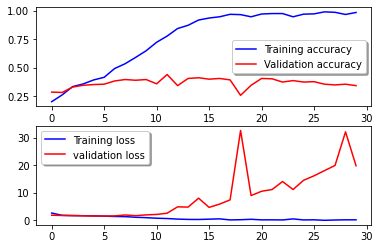

In [16]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

In [17]:
base_model1 = tf.keras.applications.ResNet50(input_shape=(128, 128, 3), include_top=False,
                          weights='imagenet')
model1 = Sequential()
model1.add(base_model1)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(64, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(num_classes, activation='softmax'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                131136    
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 455       
Total params: 23,719,559
Trainable params: 23,666,311
Non-trainable params: 53,248
_____________________________________

In [18]:
model1.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [19]:
hist1=model1.fit(X_train,Y_train,epochs=30,batch_size=5,validation_data=(X_test,Y_test))

Epoch 1/30
148/148 [==============================] - 161s 1s/step - loss: 2.1287 - accuracy: 0.2022 - val_loss: 122456.9688 - val_accuracy: 0.1167
Epoch 2/30
148/148 [==============================] - 150s 1s/step - loss: 2.0757 - accuracy: 0.1628 - val_loss: 1.9054 - val_accuracy: 0.2177
Epoch 3/30
148/148 [==============================] - 153s 1s/step - loss: 1.9899 - accuracy: 0.1954 - val_loss: 1.8841 - val_accuracy: 0.1703
Epoch 4/30
148/148 [==============================] - 148s 997ms/step - loss: 1.9391 - accuracy: 0.1832 - val_loss: 1.8806 - val_accuracy: 0.1798
Epoch 5/30
148/148 [==============================] - 155s 1s/step - loss: 1.9033 - accuracy: 0.2008 - val_loss: 1.8809 - val_accuracy: 0.1798
Epoch 6/30
148/148 [==============================] - 167s 1s/step - loss: 1.9187 - accuracy: 0.2049 - val_loss: 1.8745 - val_accuracy: 0.1703
Epoch 7/30
148/148 [==============================] - 164s 1s/step - loss: 1.8896 - accuracy: 0.2035 - val_loss: 1.8773 - val_accuracy

In [20]:
model1.evaluate(X_test, Y_test)
model1.save("D:\DL\Skin-cancer\model\ResNet.h5")

10/10 [==============================] - 8s 779ms/step - loss: 1.9083 - accuracy: 0.3091


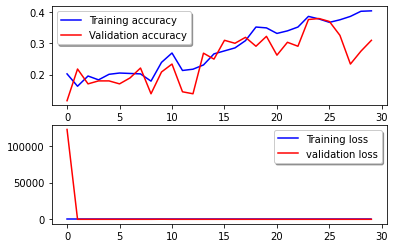

In [21]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist1.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist1.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist1.history['loss'], color='b', label="Training loss")
ax[1].plot(hist1.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

In [22]:
base_model2=tf.keras.applications.Xception(input_shape=(128, 128, 3),include_top=False,weights=None)

model2 = Sequential()
model2.add(base_model2)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(num_classes, activation='softmax'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                131136    
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 455       
Total params: 20,993,327
Trainable params: 20,938,671
Non-trainable params: 54,656
_____________________________________

In [23]:
model2.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [24]:
hist2=model2.fit(X_train,Y_train,epochs=30,batch_size=5,validation_data=(X_test,Y_test))

Epoch 1/30
148/148 [==============================] - 162s 1s/step - loss: 2.1249 - accuracy: 0.1981 - val_loss: 2.2569 - val_accuracy: 0.0915
Epoch 2/30
148/148 [==============================] - 150s 1s/step - loss: 2.0457 - accuracy: 0.1628 - val_loss: 1.9530 - val_accuracy: 0.1861
Epoch 3/30
148/148 [==============================] - 170s 1s/step - loss: 1.9644 - accuracy: 0.2252 - val_loss: 1.9261 - val_accuracy: 0.2303
Epoch 4/30
148/148 [==============================] - 167s 1s/step - loss: 1.9515 - accuracy: 0.2022 - val_loss: 1.9275 - val_accuracy: 0.1830
Epoch 5/30
148/148 [==============================] - 166s 1s/step - loss: 1.9291 - accuracy: 0.1981 - val_loss: 81.2572 - val_accuracy: 0.0631
Epoch 6/30
148/148 [==============================] - 167s 1s/step - loss: 1.8559 - accuracy: 0.2320 - val_loss: 5.3894 - val_accuracy: 0.1830
Epoch 7/30
148/148 [==============================] - 168s 1s/step - loss: 1.8431 - accuracy: 0.2646 - val_loss: 6.7179 - val_accuracy: 0.211

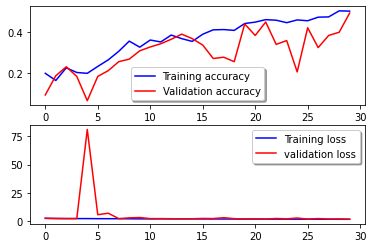

In [25]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist2.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist2.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist2.history['loss'], color='b', label="Training loss")
ax[1].plot(hist2.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

In [26]:
model2.evaluate(X_test, Y_test)
model2.save("D:\DL\Skin-cancer\model\Xception.h5")

10/10 [==============================] - 8s 786ms/step - loss: 1.4039 - accuracy: 0.4953


In [27]:
Accuracy = []

for i in [hist, hist1, hist2]:
    x = i.history.get('accuracy')[-1]
    Accuracy.append(x)

Accuracy

[0.9837177991867065, 0.4029850661754608, 0.5047490000724792]

[0.0000000e+00 4.4998183e-28 7.2864696e-15 3.1211806e-28 1.4545745e-31
 5.4629760e-31 1.0000000e+00]


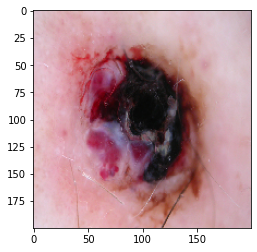

Prediction: Vascular lesions


In [32]:
from skimage import io
from keras.preprocessing import image

img = image.load_img(r'D:\DL\Skin-cancer\hamdata\Vascular lesions\ISIC_0032775.jpg', grayscale=False, target_size=(128,128))
show_img=image.load_img(r'D:\DL\Skin-cancer\hamdata\Vascular lesions\ISIC_0032775.jpg', grayscale=False, target_size=(200, 200))
Disease = ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Dermatofibroma', 'Melanocytic nevi', 'Melanoma', 'Vascular lesions']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
print(custom[0])


plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',Disease[ind])